## Imports and Set Run Parameters

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# set parameters
label = 'deaths'
percent_test = 0.5
lag_window = [i+7 for i in range(7)]
lag_window

[7, 8, 9, 10, 11, 12, 13]

## Load and Explore Data

In [3]:
# Load Data
df_ny = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df_meta_data = pd.read_csv('../ACS_full_data_wo_over_60.csv')
# df_meta_data = pd.read_csv('https://raw.githubusercontent.com/emmamackay/ML1-Group4/master/ACS_full_data_wo_over_60.csv?token=ANUVMQO3NBFRDM64WCTGJDK6WN6NE')

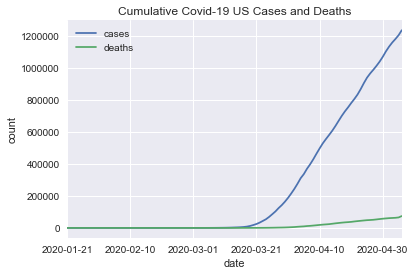

In [4]:
# plot total US cases
case_counts = df_ny[['date','cases','deaths']].groupby('date').sum()
ax = case_counts.plot(title='Cumulative Covid-19 US Cases and Deaths')
ax.set_ylabel("count")

plt.savefig('images/case_counts.png')

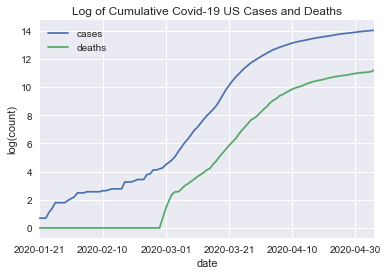

In [5]:
# plot log of US Cases
df_ny1 = df_ny.copy()
case_counts = df_ny1[['date','cases','deaths']].groupby('date').sum()
case_counts['cases'] = np.log(case_counts['cases'] + 1)
case_counts['deaths'] = np.log(case_counts['deaths'] + 1)
ax = case_counts.plot(title='Log of Cumulative Covid-19 US Cases and Deaths')
ax.set_ylabel("log(count)")
case_counts.head()
plt.savefig('images/logcase_counts.png')

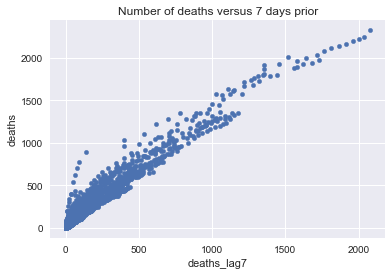

In [6]:
# plot cases versus cases from 7 days prior by fips
df_ny2 = df_ny.copy()
for i in [6]:
    df_ny2[f'cases_lag{str(i+1)}'] = df_ny2.groupby(['fips'])['cases'].shift((i+1))
    df_ny2[f'deaths_lag{str(i+1)}'] = df_ny2.groupby(['fips'])['deaths'].shift((i+1))
    

df_ny2.plot.scatter(x='deaths_lag7',y='deaths', title='Number of deaths versus 7 days prior')
plt.savefig('images/deaths_7d.png')

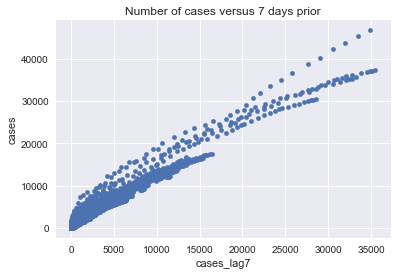

In [7]:
df_ny2.plot.scatter(x='cases_lag7',y='cases', title='Number of cases versus 7 days prior')
plt.savefig('images/cases_7d.png')

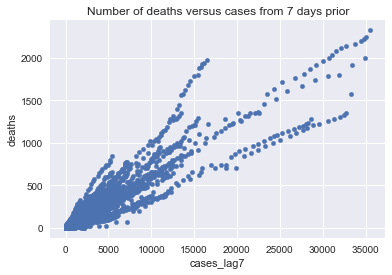

In [8]:
df_ny2.plot.scatter(x='cases_lag7',y='deaths', title='Number of deaths versus cases from 7 days prior')
plt.savefig('images/cases_deaths_7d.png')

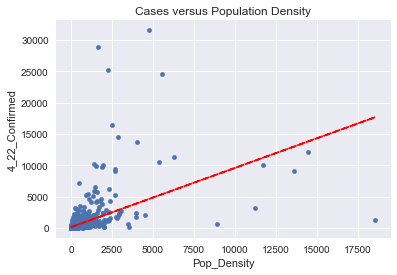

In [9]:
import matplotlib.pyplot as plt
df_meta_data.plot.scatter('Pop_Density', '4_22_Confirmed')
z = np.poly1d(np.polyfit(df_meta_data['Pop_Density'], df_meta_data['4_22_Confirmed'], 1))
ax = plt.plot(df_meta_data['Pop_Density'],z(df_meta_data['Pop_Density']),"r--")
plt.title('Cases versus Population Density')
plt.savefig('images/cases_pop.png')

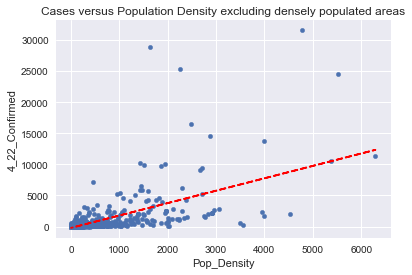

In [10]:
df_meta_data1 = df_meta_data[df_meta_data['Pop_Density'] < 7500]
df_meta_data1.plot.scatter('Pop_Density', '4_22_Confirmed')
z = np.poly1d(np.polyfit(df_meta_data1['Pop_Density'], df_meta_data1['4_22_Confirmed'], 1))
plt.plot(df_meta_data1['Pop_Density'],z(df_meta_data1['Pop_Density']),"r--")
plt.title('Cases versus Population Density excluding densely populated areas')
plt.savefig('images/cases_pop_noout.png')

In [11]:
from scipy.stats import spearmanr
print(spearmanr(df_meta_data[['Pop_Density']].values, df_meta_data[['4_22_Confirmed']].values))
print(df_meta_data[['Pop_Density', '4_22_Confirmed']].corr())

SpearmanrResult(correlation=0.7272491091466564, pvalue=3.515313646282204e-243)
                Pop_Density  4_22_Confirmed
Pop_Density        1.000000        0.501955
4_22_Confirmed     0.501955        1.000000


## Clean/Tranform and Merge Data

In [12]:
# data clease cases - filter out entries with fewer than 10 deaths
df_ny = df_ny[['date','state','county', 'fips','cases','deaths']]
df_ny = df_ny[df_ny['deaths']>=10]
df_ny['state'] = df_ny['state'].str.lower()

In [13]:
# data clease meta - transform state for join
df_meta_data = df_meta_data.rename(str.lower, axis = 'columns')
df_meta_data['state'] = df_meta_data['state'].str.lower()

In [14]:
# merge data on cases with meta data
df_merged = pd.merge(df_ny, df_meta_data, how = 'inner', left_on=["county", "state"], right_on=["county", "state"])

In [15]:
# create lagged data
for i in lag_window:
    df_merged[f'cases_lag{str(i+1)}'] = df_merged.groupby(['fips'])['cases'].shift((i+1))
    df_merged[f'deaths_lag{str(i+1)}'] = df_merged.groupby(['fips'])['deaths'].shift((i+1))

In [16]:
# create additional features
df_merged['pctMale'] = df_merged['e_total_pop_sex_male']/df_merged['et_total_population']
df_merged['pctSS'] = df_merged['e_total_households_with_income_with_social_security']/df_merged['et_total_population']
df_merged['pctRetInc'] = df_merged['e_total_households_with_income_with_retirement_income']/df_merged['et_total_population']
df_merged['pctWhite'] = df_merged['e_total_pop_race_white']/df_merged['et_total_population']
df_merged['pctPoverty'] = df_merged['e_total_pop_poverty_status_below_100_percent']/df_merged['et_total_population']

## Split Train and Test and Standardize Features

In [17]:
# split into train and test based on county (fips)
num_train = int(len(df_merged['fips'].unique()))
unique_counties_np = df_merged['fips'].unique()
unique_counties = pd.DataFrame(data = unique_counties_np)

train_counties = unique_counties.sample(int(num_train * (1-percent_test)))
test_counties = unique_counties.loc[~unique_counties.index.isin(train_counties.index)]

In [18]:
# extract train and test data
train_counties = train_counties[0].values.tolist()
test_counties = test_counties[0].values.tolist()
df_train = df_merged[df_merged['fips'].isin(train_counties)]
df_test =  df_merged[df_merged['fips'].isin(test_counties)]

df_train= df_train.dropna()
df_test= df_test.dropna()

In [19]:
# standardize features - train and test separately
s0 = df_train.iloc[:,4:]
df_train.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

s0 = df_test.iloc[:,4:]
df_test.iloc[:,4:] = (s0 - s0.mean()) / (s0.max() - s0.min())

# Benchmark - Linear Regression

In [20]:
# extract features and targets
feature_list = ['pop_density','et_total_population', 'em_total_pop_median_age', 'em_transportation_mean_travel_time', 'em_total_housing_units_avg_household_size_rented', 'pctMale', 'pctSS', 'pctRetInc', 'pctWhite', 'pctPoverty']
feature_list.extend([f'cases_lag{i+1}' for i in lag_window])
feature_list.extend([f'deaths_lag{i+1}' for i in lag_window])

In [21]:
import d2l
from mxnet import autograd, gluon, np, npx, init
npx.set_np()
import pandas as pd
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn

In [22]:
train_labels = np.array(df_train[[label]].values, dtype=np.float32).reshape(-1, 1)
train_features = np.array(df_train[feature_list].values, dtype=np.float32)
test_labels = np.array(df_test[[label]].values, dtype=np.float32).reshape(-1, 1)
test_features = np.array(df_test[feature_list].values, dtype=np.float32)
train_features=train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
test_features=test_features.reshape((test_features.shape[0], test_features.shape[1], 1))

In [23]:
# Copied from d2l textbook
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 8 # train set size is divisible by 12
train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size, is_train=False)

In [24]:
# initialize model
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001})

In [25]:
# run model and save loss results
results_list = []
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(train_features), train_labels)
    l_test = loss(net(test_features), test_labels)
    
    results_dict = {'epoch': epoch + 1, 
                'train_loss': l.mean(), 
                'test_loss': l_test.mean()}
    results_list.append(results_dict)
    print('epoch %d, loss_train: %f, loss_test: %f' % (epoch, l.mean().asnumpy(), l_test.mean().asnumpy()))

epoch 1, loss_train: 0.009914, loss_test: 0.007696
epoch 2, loss_train: 0.009055, loss_test: 0.007075
epoch 3, loss_train: 0.008278, loss_test: 0.006513
epoch 4, loss_train: 0.007573, loss_test: 0.006004
epoch 5, loss_train: 0.006935, loss_test: 0.005543
epoch 6, loss_train: 0.006356, loss_test: 0.005126
epoch 7, loss_train: 0.005831, loss_test: 0.004749
epoch 8, loss_train: 0.005356, loss_test: 0.004408
epoch 9, loss_train: 0.004925, loss_test: 0.004099
epoch 10, loss_train: 0.004534, loss_test: 0.003819
epoch 11, loss_train: 0.004179, loss_test: 0.003566
epoch 12, loss_train: 0.003858, loss_test: 0.003337
epoch 13, loss_train: 0.003567, loss_test: 0.003129
epoch 14, loss_train: 0.003302, loss_test: 0.002942
epoch 15, loss_train: 0.003063, loss_test: 0.002772
epoch 16, loss_train: 0.002845, loss_test: 0.002618
epoch 17, loss_train: 0.002648, loss_test: 0.002478
epoch 18, loss_train: 0.002469, loss_test: 0.002352
epoch 19, loss_train: 0.002307, loss_test: 0.002238
epoch 20, loss_train:

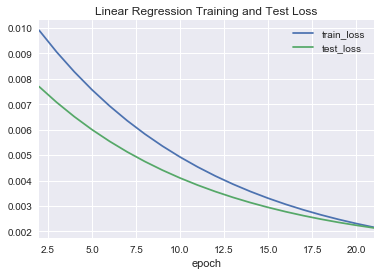

In [26]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32'})

# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='Linear Regression Training and Test Loss')

# Model 2: 1D ConvNet Implementation

In [27]:
import numpy as nd
pd.options.display.max_columns = None
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from mxnet.gluon import loss as gloss
npx.set_np()

In [28]:
# extract features and targets
feature_list = ['pop_density','et_total_population', 'em_total_pop_median_age', 'em_transportation_mean_travel_time', 'em_total_housing_units_avg_household_size_rented', 'pctMale', 'pctSS', 'pctRetInc', 'pctWhite', 'pctPoverty']
feature_list.extend([f'cases_lag{i+1}' for i in lag_window])
feature_list.extend([f'deaths_lag{i+1}' for i in lag_window])

In [29]:
train_labels = np.array(df_train[[label]].values, dtype=np.float32).reshape(-1, 1)
train_features = np.array(df_train[feature_list].values, dtype=np.float32)
test_labels = np.array(df_test[[label]].values, dtype=np.float32).reshape(-1, 1)
test_features = np.array(df_test[feature_list].values, dtype=np.float32)
train_features=train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
test_features=test_features.reshape((test_features.shape[0], test_features.shape[1], 1))

In [30]:
net = nn.Sequential()
net.add(nn.Conv1D(channels=10, kernel_size=3, padding=2, activation='relu'),
        nn.AvgPool1D(pool_size=2, strides=1),
        nn.Dense(64, activation='relu'),
        nn.Dense(32, activation='relu'),
        nn.Dense(1))

In [31]:
X = train_features
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1823, 10, 3)
pool0 output shape:	 (1823, 10, 2)
dense1 output shape:	 (1823, 64)
dense2 output shape:	 (1823, 32)
dense3 output shape:	 (1823, 1)


In [32]:
batch_size = 10
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size)

In [33]:
from sklearn import metrics
num_epochs, lr = 20, 0.5
results_list = []
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': lr})
for epoch in range(1, num_epochs + 1):
    for i, (X, y) in enumerate(train_iter):
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(X.shape[0])
    train_loss = loss(net(train_features), train_labels)
    test_loss = loss(net(test_features), test_labels)
    train_rmse=np.sqrt(metrics.mean_squared_error(net(train_features), train_labels))
    test_rmse=np.sqrt(metrics.mean_squared_error(net(test_features), test_labels))
    results_dict = {'epoch': epoch, 
                'train_loss': train_loss.mean().asnumpy(), 
                'test_loss': test_loss.mean().asnumpy(),
                'train_rmse': train_rmse,
                'test_rmse': test_rmse}
    results_list.append(results_dict)
    
    print("epoch: {} | trn_loss: {:.8f}, test_loss: {:.8f}".format(epoch,float(train_loss.mean()), float(test_loss.mean())))
    
    
    

epoch: 1 | trn_loss: 0.01035037, test_loss: 0.00800087
epoch: 2 | trn_loss: 0.01019255, test_loss: 0.00787215
epoch: 3 | trn_loss: 0.00990038, test_loss: 0.00773401
epoch: 4 | trn_loss: 0.00166422, test_loss: 0.00177400
epoch: 5 | trn_loss: 0.00059861, test_loss: 0.00110572
epoch: 6 | trn_loss: 0.00168606, test_loss: 0.00233575
epoch: 7 | trn_loss: 0.00060730, test_loss: 0.00114640
epoch: 8 | trn_loss: 0.00138527, test_loss: 0.00179229
epoch: 9 | trn_loss: 0.00067722, test_loss: 0.00115582
epoch: 10 | trn_loss: 0.00095002, test_loss: 0.00140580
epoch: 11 | trn_loss: 0.00060344, test_loss: 0.00105236
epoch: 12 | trn_loss: 0.00059621, test_loss: 0.00107920
epoch: 13 | trn_loss: 0.00067009, test_loss: 0.00112183
epoch: 14 | trn_loss: 0.00049017, test_loss: 0.00092376
epoch: 15 | trn_loss: 0.00056742, test_loss: 0.00103179
epoch: 16 | trn_loss: 0.00120378, test_loss: 0.00169977
epoch: 17 | trn_loss: 0.00042840, test_loss: 0.00087557
epoch: 18 | trn_loss: 0.00044707, test_loss: 0.00087111
e

In [34]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32','train_rmse':'float32','test_rmse':'float32'})

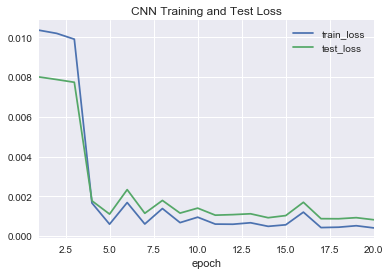

In [35]:
# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='CNN Training and Test Loss')

# Model 3: MLP Implementation

In [36]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='tanh'), # relu | tanh
        nn.Dense(256),
        nn.Dense(128, activation='tanh'),
        nn.Dense(1))

net.initialize()

In [37]:
batch_size = 10
train_iter = load_array((train_features, train_labels), batch_size)
test_iter = load_array((test_features, test_labels), batch_size)

In [38]:
num_epochs, lr = 20, 0.1
results_list = []
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': lr})
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_iter):
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(X.shape[0])
    train_loss = loss(net(train_features), train_labels)
    test_loss = loss(net(test_features), test_labels)
    train_rmse=np.sqrt(metrics.mean_squared_error(net(train_features), train_labels))
    test_rmse=np.sqrt(metrics.mean_squared_error(net(test_features), test_labels))
    
    results_dict = {'epoch': epoch, 
                'train_loss': train_loss.mean().asnumpy(), 
                'test_loss': test_loss.mean().asnumpy(),
                'train_rmse': train_rmse,
                'test_rmse': test_rmse}
    results_list.append(results_dict)
    
    print("epoch: {} | trn_loss: {:.8f}, test_loss: {:.8f}".format(epoch,float(train_loss.mean()), float(test_loss.mean())))
    

epoch: 0 | trn_loss: 0.00195936, test_loss: 0.00191330
epoch: 1 | trn_loss: 0.00073764, test_loss: 0.00114151
epoch: 2 | trn_loss: 0.00069220, test_loss: 0.00110223
epoch: 3 | trn_loss: 0.00069083, test_loss: 0.00109476
epoch: 4 | trn_loss: 0.00066247, test_loss: 0.00105190
epoch: 5 | trn_loss: 0.00064921, test_loss: 0.00103921
epoch: 6 | trn_loss: 0.00065475, test_loss: 0.00102879
epoch: 7 | trn_loss: 0.00063716, test_loss: 0.00101223
epoch: 8 | trn_loss: 0.00062274, test_loss: 0.00099955
epoch: 9 | trn_loss: 0.00061415, test_loss: 0.00098522
epoch: 10 | trn_loss: 0.00060179, test_loss: 0.00096885
epoch: 11 | trn_loss: 0.00059142, test_loss: 0.00095287
epoch: 12 | trn_loss: 0.00058640, test_loss: 0.00094610
epoch: 13 | trn_loss: 0.00057631, test_loss: 0.00092799
epoch: 14 | trn_loss: 0.00057319, test_loss: 0.00092373
epoch: 15 | trn_loss: 0.00058654, test_loss: 0.00093266
epoch: 16 | trn_loss: 0.00055666, test_loss: 0.00089982
epoch: 17 | trn_loss: 0.00055513, test_loss: 0.00089705
ep

In [39]:
# extract results
df_out = pd.DataFrame(results_list)
df_out = df_out.astype({'train_loss': 'float32', 'test_loss': 'float32','train_rmse':'float32','test_rmse':'float32'})

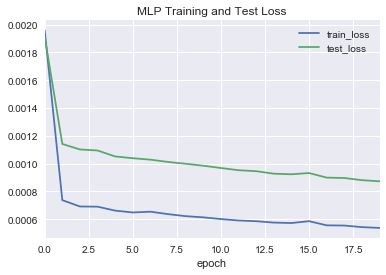

In [40]:
# plot results
df_out.plot(x='epoch', y=['train_loss', 'test_loss'], title='MLP Training and Test Loss')